# Classification Demo

The goal of this demo project is to build a predictive model to classify test-instances into "M" and "R" classes. It involves following steps: reading dummy datasets in CSV and XML formats, merging them, processing, and model building. Model building involves feature selection and hyperparamenter tuning using cross-validation, and evaluation of performance metrics.

In [1]:
import pandas as pd
import os
import numpy as np
import lxml
import xml.etree.cElementTree as et
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_predict, cross_validate, cross_val_score
from sklearn import metrics

In [2]:
# Read data in XML format
def read_xml(path):
    xml = et.parse(path)# row = rows[1]
    df = []
    for row in xml.getroot():
        dic = {}
        for r in row:
            dic[r.tag] = r.text
        df.append(dic)
    df = pd.DataFrame(df)
    return df

In [3]:
DATA_DIRECTORY = "./dataset"

# Read data in CSV and XML format
df1 = pd.read_csv(os.path.join(DATA_DIRECTORY, "data1.csv"), na_values = ["NA"])
df2 = read_xml(os.path.join(DATA_DIRECTORY, "data2.xml"))
df3 = pd.read_json(os.path.join(DATA_DIRECTORY, "data3.json"))

In [4]:
def preprocess(df):
    """
    Carries out minimal cleaning of dataset to fill missing values with NAN and convert
    feature columns to numberic data (if it is not already numeric).
    """
    df.fillna(np.nan, inplace=True)
    df.replace("NA", np.nan, inplace=True)

    for col in df.columns[df.columns != "Class"]:
        df[col] = pd.to_numeric(df[col])
    return df

df1 = preprocess(df1)
df2 = preprocess(df2)
df3 = preprocess(df3)

In [5]:
# Join datasets along column
df = pd.merge(df1, df2, on= "ID")
df = pd.merge(df, df3, on= "ID")

print("Number of rows in merged dataset",df.shape[0])
print("Number of columns in merged dataset",df.shape[1])

Number of rows in merged dataset 208
Number of columns in merged dataset 62


In [6]:
# Drop rows with missing data (i.e. no imputation)
df.dropna(inplace=True)
print("Number of rows in new dataset: ", len(df))

Number of rows in new dataset:  203


In [7]:
print("Percentage of rows containing “M” vs “R” in the Class attribute:")
df['Class'].value_counts() *100.0 /len(df) 

Percentage of rows containing “M” vs “R” in the Class attribute:


M    52.70936
R    47.29064
Name: Class, dtype: float64

### Exploratory Analysis

Some exploratory analysis

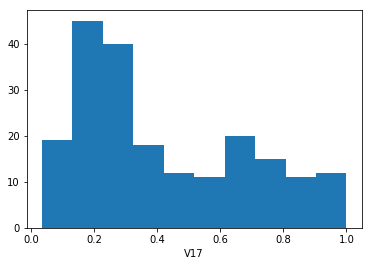

In [8]:
plt.hist(df['V17'], bins= None)
plt.xlabel('V17')
plt.show()

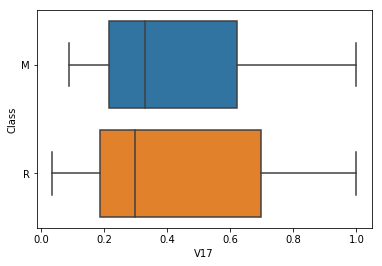

In [9]:
sns.boxplot(x = df['V17'], y = df['Class'])

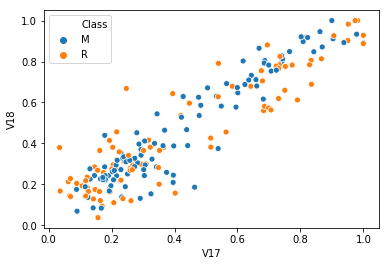

In [10]:
sns.scatterplot(x="V17", y="V18", hue="Class", data=df)

# ML Model

In [11]:
def select_important_features(X_train, y_train, rfc = None):
    """
    Tree based feature selection.
    
    Features are selected based on the median feature_importances_ values of 10 estimators
    output by 10-fold cross validation of the training data.
    
    Parameters
    ----------
    X_train : pandas dataframe, shape (n_samples, n_features)
              Training data.
    
    y_train : pandas dataframe, shape (n_samples)
            Target data.

    feature_names: list of all features the dataset
    
    Returns
    -------
    df : pandas dataframe consisting of extracted features
    """
    rfc = RandomForestClassifier(n_estimators=30, n_jobs=6)
    scores_train_cv = cross_validate(rfc, X_train, y_train, cv =10, n_jobs = 6, return_estimator = True,
                                 scoring = ['accuracy', 'precision', 'recall', 'roc_auc'],
                                    return_train_score=True)
    
    
    cv_metrics = {'cv'+k[4:]: scores_train_cv[k].mean() for k in ['test_accuracy', 'test_precision', 
                                                                  'test_recall', 'test_roc_auc']}
    cv_metrics_train = {'cv'+k[4:]: scores_train_cv[k].mean() for k in ['train_accuracy', 'train_precision', 
                                                                  'train_recall', 'train_roc_auc']}

    # Compile important features
    important_features = []
    for est in scores_train_cv['estimator']:
        important_features.append(est.feature_importances_)

    important_features = pd.DataFrame(important_features, columns= X_train.columns).T.mean(axis =1)
    important_features.sort_values(ascending=False, inplace=True)
    return important_features, cv_metrics, cv_metrics_train


def hyperparameter_tuning(X_train, y_train):
    """
    Randomized Search
    
    Hyperparameter tuning and selection of the best model using Randomized Search
    Parameters
    ----------
    X_train : array-like, shape (n_samples, n_features)
              Training data.
    
    y_train : array-like, shape (n_samples)
    
    Returns
    -------
    rand_search : object
    """
    param_rand = {'n_estimators': [80], 
                  'min_samples_split' : [15, 20, 30, 40],
                  'max_features': [10, 20, 30],
                  'max_depth': [ 3, 5, 7, 10, 20, 30]}

    # Randomized search using 10-fold cross validation
    clf = RandomForestClassifier(n_jobs=6)
    rand_search = RandomizedSearchCV(clf, param_rand, scoring = 'roc_auc', cv = 10, n_jobs=6)
    rand_search.fit(X_train, y_train)
    return rand_search

def evaluate_model_on_test_set(rfc, X_test, y_test, results_dir = os.path.join(".", "results")):
    '''
    Testing
    
    Evaluate model on test set (out of sample data)
    
    Parameters
    ----------
    X_test : array-like, shape (n_samples, n_features)
              Testing data.
    
    y_test : array-like, shape (n_samples)
             Target
    
    Returns
    -------
    results_dict : dict of performance metrics
    """
    
    '''
    y_test_pred = rfc.predict_proba(X_test)
    file_name = os.path.join(results_dir, 'performance_metrics.json')
    
    # Confusion matrix
    conf_mat = metrics.confusion_matrix(y_test, y_test_pred[:, 1] > 0.5)
    print()
    print("Confusion Matrix:")
    print("-------------------")
    print(conf_mat, "\n")
    
    tn, fp, fn, tp = conf_mat.ravel()

    # Compute metrics
    results_dict = {'ROC AUC': metrics.roc_auc_score(y_test, y_test_pred[:,1]),
                    'Accuracy': metrics.accuracy_score(y_test, y_test_pred[:, 1] > 0.5),
                    'Precision': metrics.precision_score(y_test, y_test_pred[:,1]>0.5),
                    'Recall': metrics.recall_score(y_test, y_test_pred[:,1]>0.5),
                    'Specificity' : 1.0*tn/(tn + fp),
                    'F1 score':  metrics.f1_score(y_test, y_test_pred[:,1]>0.5)}
    
    print('Performance Metrics')
    print('===================')
    for key, value in results_dict.items():
        print(key, ':', value)
    
    # Plot ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred[:,1])
    f1 = plt.figure()
    plt.plot(fpr, tpr,  'k')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC = '+ str(results_dict['ROC AUC'])[0:6])
    plt.savefig( os.path.join(results_dir, 'roc_auc.png'))
    plt.show()
    
    # Precision-recall curve
    precisions, recall, thresholds = metrics.precision_recall_curve(y_test, y_test_pred[:,1])
    f1_score = 2.0/(1.0/(precisions + 0.0001) + 1.0/(recall + 0.0001))
    f2_score = (2.0**2 + 1.0)/(1.0/(precisions + 0.0001) + 2.0**2/(recall + 0.0001))
    f2 = plt.figure()
    plt.plot(thresholds, precisions[:-1], 'g-', label = "Precision")
    plt.plot(thresholds, recall[:-1],  'b-', label = "Recall")
    plt.plot(thresholds, f1_score[:-1],  'r--', label = "F1 Score")
    plt.plot(thresholds, f2_score[:-1],  'k--', label = "F2 Score")
    plt.xlabel("Threshold")
    plt.legend(loc = "lower left")
    plt.savefig( os.path.join(results_dir, 'precision_recall.png'))
    plt.show()


In [12]:
df_copy = df.copy()
#df_copy = df_copy.sample(frac=1)
df_copy.index = df_copy['ID']
df_copy.drop('ID', inplace=True, axis =1)
X = df_copy.drop('Class', axis =1)

# Considering 'R' to be positive class and 'M' to to be negative
y = df_copy['Class'].apply(lambda x: 1 if x == "R" else 0)

In [13]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y, test_size = 0.3,shuffle = True, random_state = 130)

In [14]:
# Select important features
important_features, cv_metrics, cv_metrics_train = select_important_features(X_train, y_train)

top_10_features = important_features[0:10].index.values.tolist()
X_train_sel_10 = X_train[top_10_features]
X_test_sel_10 = X_test[top_10_features]

In [15]:
# Select features with "feature importance" better than the median value (i.e. 30 out of 60 features)
top_30_features = important_features[important_features >= important_features.median()].index.values.tolist()

# Create train and test datasets based on selected features
X_train_sel_30 = X_train[top_30_features]
X_test_sel_30 = X_test[top_30_features]

In [16]:
# Hyperparameter tuning
clf = hyperparameter_tuning(X_train_sel_30, y_train)
clf = clf.best_estimator_

/Users/user1/Envs/py367/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



Confusion Matrix:
-------------------
[[26  6]
 [ 8 21]] 

Performance Metrics
ROC AUC : 0.8448275862068966
Accuracy : 0.7704918032786885
Precision : 0.7777777777777778
Recall : 0.7241379310344828
Specificity : 0.8125
F1 score : 0.75


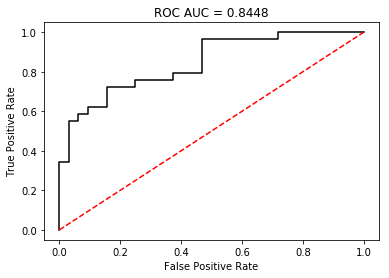

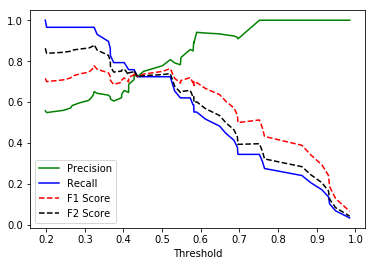

In [17]:
# Performance metrics on Test Data
evaluate_model_on_test_set(clf, X_test_sel_30, y_test)

*The ROC AUC of this model trained using 30 features is 0.89, which is a pretty good. There is some room for improving recall by using lower probability threshold, while sacrificing a little bit of precision. Furthermore, there is overfitting in the model as indicated by the higher performance metrics on "Training Data" (see below). The overfitting can be addressed by further hyperparamer tuning and/or more data (note that train dataset has only 142 examples).*


Confusion Matrix:
-------------------
[[75  0]
 [ 0 67]] 

Performance Metrics
ROC AUC : 1.0
Accuracy : 1.0
Precision : 1.0
Recall : 1.0
Specificity : 1.0
F1 score : 1.0


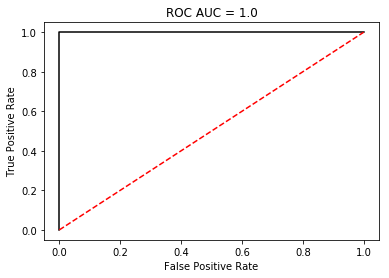

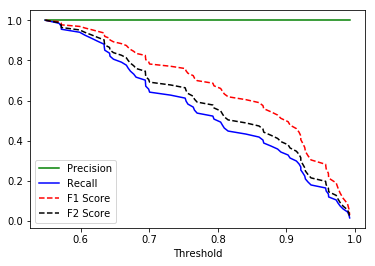

In [18]:
# Performance metrics on TRAIN Data
evaluate_model_on_test_set(clf, X_train_sel_30, y_train)